# Day 8 Analysis

For Day 8, let's look at the relationship between target share and fantasy points for receivers and see who might be due for a positive or negative regression to the mean.

## Set Up

In [2]:
import pandas as pd
from os import path
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Create database connection
conn = sqlite3.connect('../data/db/database.db')

## Target Share vs. Fantasy Points
Let's get target share and fantasy points scored for receivers going back to 1999. We should see a positive relationship – as target share increase, fantasy points scored should increase as well.

In [3]:
query = """
SELECT
    player_id,
    player_display_name AS player_name,
    season,
    week,
    receptions,
    targets,
    (1.0 * receptions/targets) AS tgt_conv,
    receiving_yards AS yds,
    receiving_tds AS tds,
    receiving_air_yards AS air_yds,
    receiving_yards_after_catch AS yac,
    ROUND(target_share,3) AS tgt_share,
    ROUND(air_yards_share,3) AS air_yds_share,
    ROUND(fantasy_points,2) AS fantasy_pts,
    ROUND(fantasy_points_ppr,2) AS fantasy_pts_ppr
FROM weekly 
WHERE position = 'WR'
    AND season_type = 'REG'
"""

df_all = pd.read_sql(query, conn)

print(df_all.shape)
df_all.head()

(43959, 15)


,player_id,player_name,season,week,receptions,targets,tgt_conv,yds,tds,air_yds,yac,tgt_share,air_yds_share,fantasy_pts,fantasy_pts_ppr
0,00-0000145,Derrick Alexander,1999,1,6,10,0.600000,154.0,1,0.0,0.0,0.244,0.0,21.4,27.4
1,00-0000145,Derrick Alexander,1999,2,6,7,0.857143,117.0,0,0.0,0.0,0.412,0.0,11.7,17.7
2,00-0000145,Derrick Alexander,1999,3,3,6,0.500000,69.0,0,0.0,0.0,0.207,0.0,6.9,9.9
3,00-0000145,Derrick Alexander,1999,4,1,7,0.142857,14.0,0,0.0,0.0,0.194,0.0,1.4,2.4
4,00-0000145,Derrick Alexander,1999,5,2,5,0.400000,25.0,0,0.0,0.0,0.200,0.0,2.5,4.5


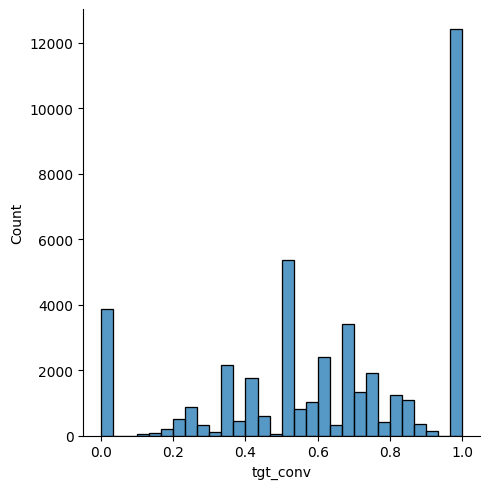

In [4]:
# Check distribution
sns.displot(
    x="tgt_conv",
    data=df_all,
    kind="hist",
    bins = 30
)

In [92]:
df_all[df_all['tgt_share'] == 0]

,player_id,player_name,season,week,receptions,targets,yds,tds,air_yds,yac,tgt_share,air_yds_share,fantasy_pts,fantasy_pts_ppr
10447,00-0022124,Taylor Jacobs,2004,3,0,0,0.0,0,0.0,0.0,0.0,0.0,2.0,2.0
10638,00-0022889,Reggie Williams,2004,6,0,0,0.0,0,0.0,0.0,0.0,0.0,2.0,2.0
24843,00-0029702,Juron Criner,2012,9,0,0,0.0,0,0.0,0.0,0.0,0.0,2.0,2.0
40450,00-0036182,Nick Westbrook-Ikhine,2020,6,0,0,0.0,0,0.0,0.0,0.0,0.0,2.0,2.0


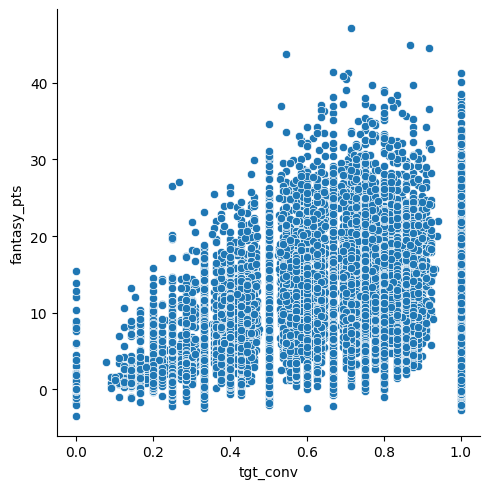

In [5]:
sns.relplot(
    x="tgt_conv",
    y="fantasy_pts",
    data=df_all
)

In [6]:
print(f"Correlation Coefficient: {df_all['tgt_conv'].corr(df_all['fantasy_pts'])}")

Correlation Coefficient: 0.2616270714815892


/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_58245/1618784583.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_avg = df_all.groupby('player_id').mean()


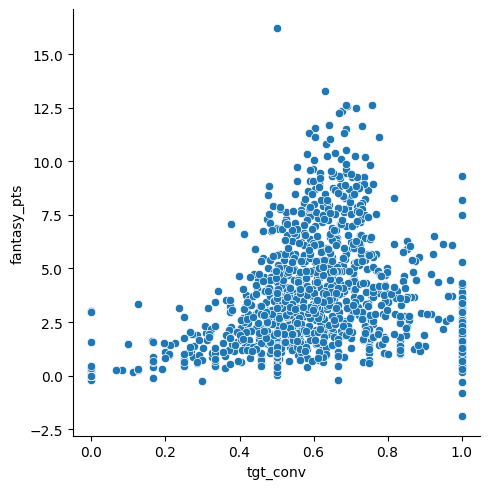

In [7]:
# Check average
df_avg = df_all.groupby('player_id').mean()

sns.relplot(
    x="tgt_conv",
    y="fantasy_pts",
    data=df_avg
)

In [9]:
col_order = ['player_name', 'season', 'week', 'receptions', 'targets', 'tgt_conv', 'yds', 'tds',
       'air_yds', 'yac', 'tgt_share', 'air_yds_share', 'fantasy_pts',
       'fantasy_pts_ppr']

df_avg = df_avg.sort_values('fantasy_pts', ascending=False) \
    .reset_index() \
    .merge(
        df_all[['player_id','player_name']].drop_duplicates(), 
        how='left'
    )[col_order]

df_avg.head(10)


KeyError: "['tgt_conv'] not in index"

In [10]:
df_avg.sort_values('tgt_conv', ascending=False)

KeyError: 'tgt_conv'

## Air Yards vs. Fantasy Points: 2022

In [111]:
f_2022 = df_all['season'] == 2022

df_2022 = df_all[f_2022].groupby('player_id').mean()

df_2022 = df_2022.sort_values('fantasy_pts', ascending=False) \
    .reset_index() \
    .merge(
        df_all[['player_id','player_name']].drop_duplicates(), 
        how='left'
    )[col_order]

df_2022.head(10)

/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_50613/1435273569.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_2022 = df_all[f_2022].groupby('player_id').mean()


,player_name,tgt_share,fantasy_pts,fantasy_pts_ppr
0,Stefon Diggs,0.287429,16.914286,24.771429
1,DeAndre Hopkins,0.392500,16.100000,27.100000
2,Cooper Kupp,0.324714,15.385714,24.528571
3,Tyreek Hill,0.321375,13.825000,22.450000
4,Justin Jefferson,0.290286,13.774286,21.202857
5,A.J. Brown,0.318429,13.700000,19.271429
6,Ja'Marr Chase,0.275143,13.528571,20.242857
7,Jaylen Waddle,0.216875,12.800000,18.050000
8,Michael Thomas,0.201000,11.700000,17.033333
9,Davante Adams,0.296429,11.585714,17.014286


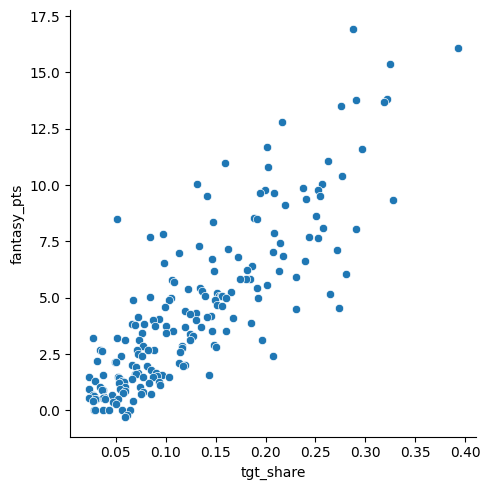

In [112]:
sns.relplot(
    x="tgt_share",
    y="fantasy_pts",
    data=df_2022
)

In [113]:
col_order = ['player_name',
       'tgt_share', 'fantasy_pts',
       'fantasy_pts_ppr']

df_2022.sort_values('tgt_share', ascending=False)[col_order].head(10)

,player_name,tgt_share,fantasy_pts,fantasy_pts_ppr
1,DeAndre Hopkins,0.392500,16.100000,27.100000
24,CeeDee Lamb,0.327750,9.350000,14.600000
2,Cooper Kupp,0.324714,15.385714,24.528571
3,Tyreek Hill,0.321375,13.825000,22.450000
5,A.J. Brown,0.318429,13.700000,19.271429
9,Davante Adams,0.296429,11.585714,17.014286
32,D.J. Moore,0.290500,8.050000,12.175000
4,Justin Jefferson,0.290286,13.774286,21.202857
0,Stefon Diggs,0.287429,16.914286,24.771429
53,Drake London,0.280500,6.075000,9.825000
